First 5 rows of the dataset:
  label                                            message
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
TF-IDF Matrix - Training shape: (4457, 7441), Test shape: (1115, 7441)

Logistic Regression Evaluation Report:
              precision    recall  f1-score   support

         Ham       0.97      1.00      0.98       966
        Spam       1.00      0.77      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115

--------------------------------------------------

Naive Bayes Evaluation Report:
              precision    recall  f1-score   support

         Ham       0.98      1.00      0.

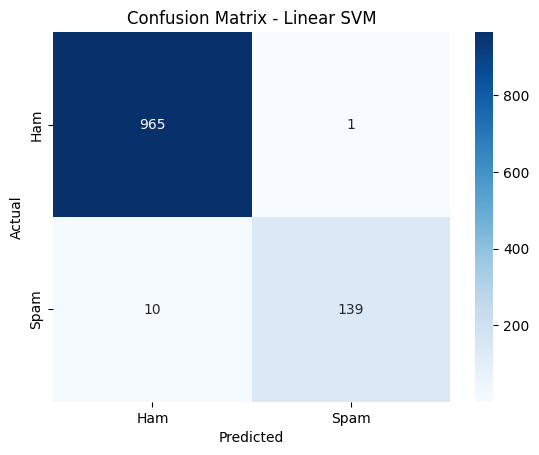

In [1]:
# 1. Import necessary libraries

import pandas as pd  # for loading and manipulating tabular data
import numpy as np   # for numerical operations
import seaborn as sns  # for visualizing data
import matplotlib.pyplot as plt  # for plotting graphs

# NLP + preprocessing
from sklearn.feature_extraction.text import CountVectorizer  # convert text into bag-of-words feature matrix
from sklearn.feature_extraction.text import TfidfVectorizer  # alternative text representation (TF-IDF)
from sklearn.model_selection import train_test_split  # to split dataset into training and test sets

# Models for classification
from sklearn.naive_bayes import MultinomialNB  # suitable for text (discrete features)
from sklearn.linear_model import LogisticRegression  # linear classifier for binary/multi-class
from sklearn.svm import LinearSVC  # support vector machine for classification
from sklearn.ensemble import RandomForestClassifier  # ensemble tree-based classifier

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# 2. Load the SMS Spam Collection dataset directly from a public GitHub raw URL
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'message'])  # load tab-separated data with custom column names

# 3. Preview the dataset
print("First 5 rows of the dataset:")
print(df.head())  # show the first few examples (label + message)

# 4. Encode the target labels: convert 'ham' to 0 and 'spam' to 1
df['label_num'] = df.label.map({'ham': 0, 'spam': 1})  # map string labels to numeric: ham=0, spam=1

# 5. Split the data into training and test sets
X = df['message']  # feature = the SMS message text
y = df['label_num']  # target = the spam/ham label as a number

# Split the data with 80% for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 6. Convert text into numeric features using TF-IDF vectorization
# TF-IDF reflects importance of words based on their frequency in a message and across all messages
vectorizer = TfidfVectorizer(stop_words='english')  # remove common stop words like "the", "is", etc.

# Learn vocabulary from training data and transform text into feature vectors
X_train_vec = vectorizer.fit_transform(X_train)  # fit on training messages and transform
X_test_vec = vectorizer.transform(X_test)  # transform test messages (do NOT fit again)

# Show feature matrix shape to understand dimensionality
print(f"TF-IDF Matrix - Training shape: {X_train_vec.shape}, Test shape: {X_test_vec.shape}")

# 7. Define multiple classifiers in a dictionary
models = {
    'Logistic Regression': LogisticRegression(max_iter=200, random_state=42),  # requires setting max_iter for convergence
    'Naive Bayes': MultinomialNB(),  # works well with text data
    'Linear SVM': LinearSVC(random_state=42),  # fast linear SVM
    'Random Forest': RandomForestClassifier(random_state=42)  # ensemble method; less common for text but included
}

# 8. Create a list to store results of each model
results = []  # holds evaluation scores for each model
conf_matrices = {}  # store confusion matrices for later visualization

# 9. Train and evaluate each model in a loop
for name, model in models.items():
    model.fit(X_train_vec, y_train)  # train the model on vectorized training data
    y_pred = model.predict(X_test_vec)  # predict labels on the test set
    
    # Compute evaluation metrics
    acc = accuracy_score(y_test, y_pred)  # percentage of correct predictions
    prec = precision_score(y_test, y_pred, zero_division=0)  # out of predicted spams, how many were correct
    rec = recall_score(y_test, y_pred, zero_division=0)  # out of actual spams, how many did we detect
    f1 = f1_score(y_test, y_pred, zero_division=0)  # harmonic mean of precision and recall
    
    # Save results
    results.append({
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    })
    
    # Save confusion matrix
    conf_matrices[name] = confusion_matrix(y_test, y_pred)
    
    # Print classification report for each model
    print(f"\n{name} Evaluation Report:")
    print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))
    print("-" * 50)

# 10. Create a DataFrame to summarize all models' results
results_df = pd.DataFrame(results)

# 11. Sort by F1 Score for better ranking
results_df_sorted = results_df.sort_values(by='F1 Score', ascending=False)

# 12. Display the sorted results
print("\nModel Performance Summary:")
print(results_df_sorted)

# 13. Plot confusion matrix of best model (based on F1 Score)
best_model_name = results_df_sorted.iloc[0]['Model']  # get name of top model
best_cm = conf_matrices[best_model_name]  # get its confusion matrix

# Plot confusion matrix using seaborn heatmap
sns.heatmap(best_cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()